In [1]:
from pysr import PySRRegressor, TemplateExpressionSpec

import matplotlib.pyplot as plt
import numpy as np

import camb

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['font.family'] = 'stixgeneral'

In [3]:
# Load Data

pars     = np.load('CL_data/parameter_test8.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL8.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL8.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [8]:
unlensed

array([[1.19082691e+02, 1.08431012e+02, 9.97814238e+01, ...,
        4.95331938e-02, 4.93220311e-02, 4.91130451e-02],
       [9.65034075e+01, 9.17852249e+01, 8.71313121e+01, ...,
        9.61021315e-02, 9.59385918e-02, 9.57770344e-02],
       [7.98318604e+01, 7.84563353e+01, 7.64367534e+01, ...,
        3.21407438e-02, 3.20790510e-02, 3.20178253e-02],
       ...,
       [1.23881981e+02, 1.12411316e+02, 1.03066207e+02, ...,
        1.64061804e-02, 1.63612086e-02, 1.63163412e-02],
       [1.54185364e+02, 1.33959852e+02, 1.19079175e+02, ...,
        4.21547911e-02, 4.20144824e-02, 4.18743606e-02],
       [1.34860753e+02, 1.19790310e+02, 1.08320878e+02, ...,
        7.68268813e-02, 7.67522414e-02, 7.66790772e-02]])

In [9]:
past_ells = 1000
n_ells = 4998 - past_ells

# Truncate to ignore first 1000 l's
y_pysr = lensed[:, past_ells:]/unlensed[:, past_ells:]

def moving_average(x):
    val = np.convolve(x, np.ones(500), 'valid') / 500
    return val

# Smoothing the Lensing Tail for Training
do_smoothing = True

if do_smoothing:
    y_pysr[:, 249:-250] = np.apply_along_axis(moving_average, axis = 1, arr = y_pysr[:, :])

# Reformatting data
y_pysr = y_pysr.reshape(-1)
# y_pysr : [par1_c502, par1_c503, ..., par1_c5000, par2_c502, ..., par299_c502, ..., par299_c5000]

In [15]:
pars_pysr.shape

(600, 3)

In [14]:
# Reformatting data
X_ells = np.array([ell for ell in range(past_ells + 2, 5000)])
pars_pysr = pars[:]
X_pysr = np.zeros((y_pysr.shape[0], 3 + 1))

In [32]:
# Reformatting data
for i in range(100):
    X_pysr[n_ells*i:n_ells*(i+1), :3] = np.tile(pars[i], n_ells).reshape(n_ells, -1)
    X_pysr[n_ells*i:n_ells*(i+1), -1] = X_ells

# make x3 = ombh2 + omch2 = om0h2
X_pysr[:, 2] = X_pysr[:, 1] + X_pysr[:, 2]


In [33]:
# Template Function

template = TemplateExpressionSpec(
    expressions = ["g"],
    variable_names = ["x1", "x2", "x3", "x4"],
    parameters = {"beta": 3},
    combine = "1 + (beta[1]*(x4/beta[2])^(g(x2, x3)) - 1)*(1 + exp(-(x4-beta[3]*2000)/100))^-1"
)

# PySR Model

model = PySRRegressor(
    niterations = 100,
    binary_operators = ["+", "-", "*", "pow"],
    constraints = {'pow': (4, 1), "*": (4, 4)},
    batching = True, 
    batch_size = 10000, 
    maxsize = 30,
    populations = 20,
    expression_spec = template,
    complexity_of_variables = 2,
    procs = 4
)


In [34]:
# Train

model.fit(X_pysr, y_pysr)

/home/grads/miniconda/envs/megan/lib/python3.9/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 0.000e+00
Progress: 0 / 2000 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.080e+00
Progress: 6 / 2000 total iterations (0.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
4           1.343e-01  0.000e+00  ╭ g = #1 + 0.010888
                         


Expressions evaluated per second: 5.830e+01
Progress: 86 / 2000 total iterations (4.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.615e-03  4.341e-04  ╭ g = #1 * -0.1606
                                  ╰ beta = [1.0678, 0.75236, -0.0022543]
7           6.575e-03  2.011e-03  ╭ g = (#2 + -0.23234) * #1
                                  ╰ beta = [1.0572, 1.5885, -0.023486]
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.840e+


Expressions evaluated per second: 4.950e+01
Progress: 145 / 2000 total iterations (7.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.575e-03  1.959e-03  ╭ g = (#2 + -0.23234) * #1
                                  ╰ beta = [1.0572, 1.5885, -0.023486]
17          6.533e-03  6.364e-04  ╭ g = ((#2 * 0.038853) - #1) - ((#1 * -0.86211) + (#1 * 0.1159...
                                  ))
                                  ╰ beta = [1.0519, 1.6078, -0.031956]
20          6.478e-03  2.845e-03  ╭ g = ((#2 * 0.063935) - #1) - (((#1 + -0.82443) * #1


Expressions evaluated per second: 6.160e+01
Progress: 200 / 2000 total iterations (10.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.575e-03  1.959e-03  ╭ g = (#2 + -0.23234) * #1
                                  ╰ beta = [1.0572, 1.5885, -0.023486]
9           6.556e-03  1.467e-03  ╭ g = (#2 + -0.23234) * (#1 * 1.3711)
                                  ╰ beta = [1.0572, 1.5885, -0.023486]
17          6.533e-03  4.286e-04  ╭ g = ((#2 * 0.038853) - #1) - ((#1 * -0.86211) + (#1 * 0.1159...
                                  ))
              


Expressions evaluated per second: 6.650e+01
Progress: 264 / 2000 total iterations (13.200%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.575e-03  1.959e-03  ╭ g = (#2 + -0.23234) * #1
                                  ╰ beta = [1.0572, 1.5885, -0.023486]
9           6.556e-03  1.467e-03  ╭ g = (#2 + -0.23234) * (#1 * 1.3711)
                                  ╰ beta = [1.0572, 1.5885, -0.023486]
17          6.533e-03  4.286e-04  ╭ g = ((#2 * 0.038853) - #1) - ((#1 * -0.86211) + (#1 * 0.1159...
                                  ))
              


Expressions evaluated per second: 7.370e+01
Progress: 318 / 2000 total iterations (15.900%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.574e-03  1.985e-03  ╭ g = #1 * (#2 + -0.15917)
                                  ╰ beta = [1.0351, 1.6098, -0.2892]
9           6.547e-03  2.084e-03  ╭ g = (#2 * 0.49744) * (-0.15917 + #2)
                                  ╰ beta = [1.0351, 1.6098, -0.2892]
11          6.520e-03  2.089e-03  ╭ g = (0.038853 * #2) + ((#1 * 0.31508) * -0.89857)
                                  ╰ beta = [1.0519, 1.6078, -0.03195

Progress: 367 / 2000 total iterations (18.350%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.507e-03  5.400e-03  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
17          6.477e-03  4.730e-04  ╭ g = ((#2 * 0.068169) - (#1 - (#1 * 0.67398))) + (#1 * -0.027...
                                  511)
                                  ╰ beta = [1.0348, 1.6064, -0.15235]
19          6.477e-03  1.016e-05  ╭ g = (#1 * 0.085414) - (((#1 * -0.21864) - (#1 * -0.8048)) + ...
                                


Expressions evaluated per second: 3.440e+01
Progress: 405 / 2000 total iterations (20.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.507e-03  5.400e-03  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
9           6.491e-03  1.247e-03  ╭ g = (#2 * 0.11955) - (#1 * 0.6486)
                                  ╰ beta = [1.0373, 1.6079, -0.15079]
14          6.467e-03  7.545e-04  ╭ g = ((#2 * 0.080009) - (#1 * 0.41052)) + (#1 * -0.024357)
                                  ╰ beta = [1.0351, 1.0664, -


Expressions evaluated per second: 3.310e+01
Progress: 451 / 2000 total iterations (22.550%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.507e-03  5.400e-03  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
9           6.470e-03  2.914e-03  ╭ g = (#2 * 0.077541) - (#1 * 0.42068)
                                  ╰ beta = [1.0373, 1.5332, -0.15079]
14          6.467e-03  8.753e-05  ╭ g = ((#2 * 0.080009) - (#1 * 0.41052)) + (#1 * -0.024357)
                                  ╰ beta = [1.0351, 1.0664,

Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 6.350e+01
Progress: 528 / 2000 total iterations (26.400%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.614e-03  4.868e-04  ╭ g = #2 * 0.0097638
                                  ╰ beta = [1.0328, 8.9613, -0.33017]
7           6.507e-03  5.400e-03  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
9           6.470e-03  2.917e-03  ╭ g = (#2 * 0.074136) - (#1 * 0.40267)
                                  ╰ beta = [1.0358, 1.533, -0.15378]
14          6.467e-03  8.635e-05  ╭ g = ((#2 * 0.080009) - (#1 * 0.41052)) + (#1 * -0.024357)
        


Expressions evaluated per second: 7.310e+01
Progress: 582 / 2000 total iterations (29.100%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.609e-03  7.371e-04  ╭ g = #2 ^ 2.9539
                                  ╰ beta = [1.0359, 11.774, -0.38267]
6           6.602e-03  5.229e-04  ╭ g = (#2 * 0.20505) ^ 1.8743
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
7           6.507e-03  1.440e-02  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
9           6.469e-03  2.923e-03  ╭ g = (#2 * 0.077107) - (#1 * 0.42068)
                                  ╰ beta = [1.0373, 1.5332, -0.15079]
14          6.467e-03 

Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.470e+01
Progress: 618 / 2000 total iterations (30.900%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.609e-03  7.371e-04  ╭ g = #2 ^ 2.9539
                                  ╰ beta = [1.0359, 11.774, -0.38267]
6           6.602e-03  5.229e-04  ╭ g = (#2 * 0.20505) ^ 1.8743
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
7           6.507e-03  1.440e-02  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
9           6.469e-03  2.923e-03  ╭ g = (#2 * 0.077107) - (#1 * 0.42068)
                                  ╰ beta


Expressions evaluated per second: 6.280e+01
Progress: 679 / 2000 total iterations (33.950%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.609e-03  7.371e-04  ╭ g = #2 ^ 2.9539
                                  ╰ beta = [1.0359, 11.774, -0.38267]
6           6.602e-03  5.229e-04  ╭ g = (#2 * 0.20505) ^ 1.8743
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
7           6.507e-03  1.440e-02  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
9           6.469e-03  2.923e-03  ╭ g = (#2 * 0.077107) - (#1 * 0.42068)
                                  ╰ beta = [1.0373, 1.5332, -0.15079]
14          6.467e-03 


Expressions evaluated per second: 5.850e+01
Progress: 736 / 2000 total iterations (36.800%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
7           6.507e-03  4.044e-03  ╭ g = (#2 * 0.18365) - #1
                                  ╰ beta = [1.0359, 11.774, -0.38267]
9           6.469e-03  2.923e-03  ╭ g = (#2 * 0.077107) - (#1 * 0.42068)
                                  ╰ beta = [1.0373, 1.5332, -0.15079]
14          6.467e-03  8.392e-05  ╭ g = ((#2 * 0.080009) - (#1 * 0.41052)) + (#1 * -0.024357)
                                  ╰ beta = [1.0351, 1.0664, -0


Expressions evaluated per second: 6.650e+01
Progress: 785 / 2000 total iterations (39.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.469e-03  1.782e-03  ╭ g = (#2 * 0.077107) - (#1 * 0.42068)
                                  ╰ beta = [1.0373, 1.5332, -0.15079]
14          6.467e-03 

Progress: 818 / 2000 total iterations (40.900%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
14          6.467e-03  3.530e-05  ╭ g = ((#2 * 0.080009) - (#1 * 0.4


Expressions evaluated per second: 4.920e+01
Progress: 842 / 2000 total iterations (42.100%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  


Expressions evaluated per second: 6.530e+01
Progress: 881 / 2000 total iterations (44.050%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  

Progress: 937 / 2000 total iterations (46.850%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  3.028e-05  ╭ g = (#2 * 0.080009) - (#1 * (0.4


Expressions evaluated per second: 5.910e+01
Progress: 973 / 2000 total iterations (48.650%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  


Expressions evaluated per second: 5.820e+01
Progress: 1015 / 2000 total iterations (50.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03 


Expressions evaluated per second: 7.460e+01
Progress: 1055 / 2000 total iterations (52.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.582e-03  3.771e-04  ╭ g = (#2 ^ 0.61029) ^ 5.3146
                                  ╰ beta = [1.0337, 7.5393, -0.7676]
7           6.493e-03  1.366e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03 

Progress: 1098 / 2000 total iterations (54.900%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.575e-03  8.873e-04  ╭ g = (#2 ^ 3.8436) * 3.9326
                                  ╰ beta = [1.0324, 13.131, -1.3703]
7           6.493e-03  1.264e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  3.028e-05  ╭ g = (#2 * 0.080009) - (#1 * (0.4


Expressions evaluated per second: 5.730e+01
Progress: 1141 / 2000 total iterations (57.050%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.573e-03  1.039e-03  ╭ g = (#2 * 1.5282) ^ 3.9707
                                  ╰ beta = [1.0322, 19.69, -1.463]
7           6.493e-03  1.234e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  3.


Expressions evaluated per second: 3.940e+01
Progress: 1162 / 2000 total iterations (58.100%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.573e-03  1.039e-03  ╭ g = (#2 * 1.5282) ^ 3.9707
                                  ╰ beta = [1.0322, 19.69, -1.463]
7           6.493e-03  1.234e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  3.

Progress: 1225 / 2000 total iterations (61.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.573e-03  1.058e-03  ╭ g = (#2 ^ 3.8307) * 3.5713
                                  ╰ beta = [1.0325, 24.958, -1.5667]
7           6.493e-03  1.230e-02  ╭ g = (#2 * 0.17348) - #1
                                  ╰ beta = [1.0433, 15.283, -0.070249]
9           6.468e-03  1.904e-03  ╭ g = (#1 * -0.39955) + (#2 * 0.076245)
                                  ╰ beta = [1.034, 1.163, -0.39391]
12          6.467e-03  3.028e-05  ╭ g = (#2 * 0.080009) - (#1 * (0.4


Expressions evaluated per second: 6.700e+01
Progress: 1282 / 2000 total iterations (64.100%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.571e-03  1.200e-03  ╭ g = (#2 ^ 4.5024) * 15.215
                                  ╰ beta = [1.0316, 29.178, -1.0738]
7           6.449e-03  1.875e-02  ╭ g = (#2 * 0.19139) - #1
                                  ╰ beta = [1.0334, 65.85, -0.29111]
───────────────────────────────────────────────────────────────────────────────────────────────────
═══════════════════════════════════════════════════════════════════

───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.449e-03  1.818e-02  ╭ g = (#2 * 0.19139) - #1
                                  ╰ beta = [1.0334, 65.85, -0.29111]
17          6.449e-03  4.768e-08  ╭ g = ((#2 * 0.19139) - #1) - ((#1 * 0.41713) * (#1 * -1.3862)...
                                  )
                                  ╰ beta = [1.0334, 65.85, -0.29111]
───────────────────────────────────────────────────────────────────────────────────────────────────
══════════════════════════════════════════════════════════


Expressions evaluated per second: 4.940e+01
Progress: 1398 / 2000 total iterations (69.900%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.449e-03  1.818e-02  ╭ g = (#2 * 0.19139) - #1
                                  ╰ beta = [1.0334, 65.85, -0.29111]
12          6.449e-03  1.574e-06  ╭ g = ((#2 * 0.19139) - #1) - (#1 * -0.0038641)
                                  ╰ beta = [1.0334, 65.85, -0.29111]
17          6.449


Expressions evaluated per second: 6.780e+01
Progress: 1436 / 2000 total iterations (71.800%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.449e-03  1.818e-02  ╭ g = (#2 * 0.19139) - #1
                                  ╰ beta = [1.0334, 65.85, -0.29111]
12          6.449e-03  1.574e-06  ╭ g = ((#2 * 0.19139) - #1) - (#1 * -0.0038641)
                                  ╰ beta = [1.0334, 65.85, -0.29111]
14          6.447

Progress: 1501 / 2000 total iterations (75.050%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.449e-03  1.822e-02  ╭ g = (#2 * 0.19266) - #1
                                  ╰ beta = [1.0339, 65.857, -0.27228]
12          6.443e-03  1.917e-04  ╭ g = (#2 * 0.21159) - (#1 - (#1 * -0.086394))
                                  ╰ beta = [1.0346, 112.58, -0.43131]
13          6.441e-03  1.905e-04  ╭ g = ((#2 * 0.21957) - #1)


Expressions evaluated per second: 6.220e+01
Progress: 1562 / 2000 total iterations (78.100%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.449e-03  1.822e-02  ╭ g = (#2 * 0.19266) - #1
                                  ╰ beta = [1.0339, 65.857, -0.27228]
10          6.439e-03  5.033e-04  ╭ g = ((0.22503 - #1) * #2) - #1
                                  ╰ beta = [1.0334, 139.72, -0.40165]
18          6.439e-03  1.922e-


Expressions evaluated per second: 5.330e+01
Progress: 1596 / 2000 total iterations (79.800%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.446e-03  1.863e-02  ╭ g = (#2 * 0.19443) - #1
                                  ╰ beta = [1.0333, 84.914, -0.28999]
10          6.439e-03  3.665e-04  ╭ g = ((0.22503 - #1) * #2) - #1
                                  ╰ beta = [1.0334, 139.72, -0.40165]
18          6.439e-03  1.922e-


Expressions evaluated per second: 6.360e+01
Progress: 1633 / 2000 total iterations (81.650%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.446e-03  1.863e-02  ╭ g = (#2 * 0.19443) - #1
                                  ╰ beta = [1.0333, 84.914, -0.28999]
10          6.439e-03  3.665e-04  ╭ g = ((0.22503 - #1) * #2) - #1
                                  ╰ beta = [1.0334, 139.72, -0.40165]
18          6.439e-03  1.922e-


Expressions evaluated per second: 6.180e+01
Progress: 1685 / 2000 total iterations (84.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.446e-03  1.863e-02  ╭ g = (#2 * 0.19443) - #1
                                  ╰ beta = [1.0333, 84.914, -0.28999]
10          6.439e-03  3.665e-04  ╭ g = ((0.22503 - #1) * #2) - #1
                                  ╰ beta = [1.0334, 139.72, -0.40165]
13          6.431e-03  4.147e-


Expressions evaluated per second: 5.380e+01
Progress: 1746 / 2000 total iterations (87.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.445e-03  1.884e-02  ╭ g = (#2 * 0.19259) - #1
                                  ╰ beta = [1.0337, 139.72, -0.40138]
10          6.439e-03  2.958e-04  ╭ g = ((0.22503 - #1) * #2) - #1
                                  ╰ beta = [1.0334, 139.72, -0.40165]
13          6.431e-03  4.147e-


Expressions evaluated per second: 4.610e+01
Progress: 1785 / 2000 total iterations (89.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.445e-03  1.884e-02  ╭ g = (#2 * 0.19259) - #1
                                  ╰ beta = [1.0337, 139.72, -0.40138]
10          6.439e-03  2.958e-04  ╭ g = ((0.22503 - #1) * #2) - #1
                                  ╰ beta = [1.0334, 139.72, -0.40165]
13          6.431e-03  4.147e-


Expressions evaluated per second: 5.170e+01
Progress: 1836 / 2000 total iterations (91.800%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
6           6.567e-03  1.483e-03  ╭ g = (#2 ^ 4.6066) * 16.93
                                  ╰ beta = [1.0318, 49.664, -1.8463]
7           6.445e-03  1.884e-02  ╭ g = (#2 * 0.19259) - #1
                                  ╰ beta = [1.0337, 139.72, -0.40138]
10          6.439e-03  2.958e-04  ╭ g = ((0.22503 - #1) * #2) - #1
                                  ╰ beta = [1.0334, 139.72, -0.40165]
13          6.431e-03  4.147e-


Expressions evaluated per second: 5.880e+01
Progress: 1887 / 2000 total iterations (94.350%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.587e-03  1.843e-03  ╭ g = #2 ^ 3.0707
                                  ╰ beta = [1.0321, 5.3192, -0.54197]
5           6.552e-03  5.372e-03  ╭ g = #2 * #2
                                  ╰ beta = [1.032, 744.23, -0.21818]
7           6.445e-03  8.217e-03  ╭ g = (#2 * 0.19259) - #1
                                  ╰ beta = [1.0337, 139.72, -0.40138]
10          6.418e-03  1.366e-03  ╭ g = ((#2 * 0.3917) - #1) - #1
                                  ╰ beta = [1.0329, 365.67, -0.37398]
15          6.409e-03  3.033e-04  ╭ g = ((#1 


Expressions evaluated per second: 6.010e+01
Progress: 1940 / 2000 total iterations (97.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.0342, 0.44754, -1.1604]
4           6.578e-03  2.301e-03  ╭ g = 0.076086 * #2
                                  ╰ beta = [1.032, 744.23, -0.21818]
5           6.552e-03  3.995e-03  ╭ g = #2 * #2
                                  ╰ beta = [1.032, 744.23, -0.21818]
7           6.445e-03  8.217e-03  ╭ g = (#2 * 0.19259) - #1
                                  ╰ beta = [1.0337, 139.72, -0.40138]
10          6.418e-03  1.366e-03  ╭ g = ((#2 * 0.3917) - #1) - #1
                                  ╰ beta = [1.0329, 365.67, -0.37398]
13          6.398e-03  1.064e-03  ╭ g = ((#2

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000  g = 0.0; beta = [1.0342405, 0.4475393, -1.1603...   
	1        0.002972  g = #2 * 0.08205655; beta = [1.0334255, 1133.6...   
	2  >>>>  0.025281  g = #2 - #1; beta = [1.0315508, 2302.7092, -0....   
	3        0.000244  g = (#1 * (-0.534351 + -0.52399504)) + #2; bet...   
	4        0.006757  g = (#1 * -0.52399504) + (#2 - #1); beta = [1....   
	5        0.002759  g = ((#1 * (-0.534351 + -0.52399504)) + #2) - ...   
	6        0.001020  g = #2 - (#1 + ((#1 + #1) - (#1 * -1.3854902))...   
	7        0.000696  g = #2 + ((#2 - (#1 * 9.283998)) + (((#2 * -0....   
	
	       loss  complexity  
	0  0.006623           1  
	1  0.006565           4  
	2  0.006401           5  
	3  0.006394           9  
	4  0.006351          10  
	5  0.006316          12  
	6  0.006291          16  
	7  0.006247          26  
]

  - outputs/20250603_152423_G3Mo0G/hall_of_fame.csv


In [35]:
ells = np.array([l for l in range(2, 5000)])

In [48]:
print(model.equations_["equation"][0])

g = 0.0; beta = [1.0342405, 0.4475393, -1.1603829]


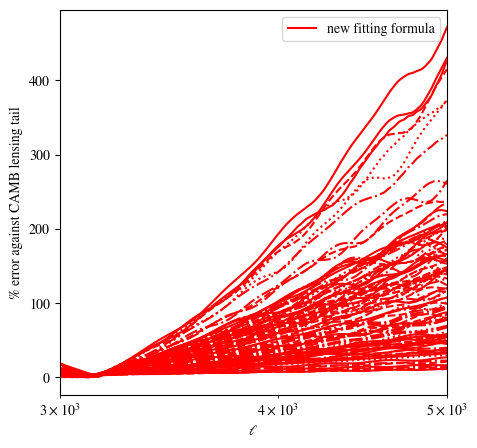

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

# Final Fit

def lensing_tail_fit(ell, ombh2, omch2):
    beta_1 = 1.03   # 0.83
    beta_2 = 1400/0.447    # 1400/0.4531
    beta_3 = -1.16    # 1.62

    # Sigmoid
    sigm = (1 + np.exp(-(ell-beta_3*2000)/100))**(-1)

    # Exponent
    alpha = (ombh2**-0.877) * (ombh2 + omch2) - 3.342*(ombh2 + omch2) - 1.118

    # Polynomial
    poly = (beta_1*(ell/beta_2)**alpha - 1)

    L = poly*sigm + 1


    return L


# Fit % Error for 100 Cosmologies
for ind in range(0, 100):
    ax.semilogx(ells, 100*np.abs(lensing_tail_fit(ells, pars[ind, 1], pars[ind, 2]) - lensed[ind]/unlensed[ind])/(lensed[ind]/unlensed[ind]), "r", label='new fitting formula')


ax.set_xlim(3000, 5000)
ax.set_xlabel("$\ell$")

ax.set_ylabel("% error against CAMB lensing tail")


handles, labels = fig.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)


In [11]:
# PLOTS BELOW vvvvv

In [12]:
pars = camb.set_params(H0 = 67.4, ombh2 = 0.0224, omch2 = 0.12, lmax=5000)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
fiducial_lensed = powers['total'][2:5000, 0]
fiducial_unlensed = powers['unlensed_total'][2:5000, 0]
ells = np.array([l for l in range(2, 5000)])

from cycler import cycler
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))


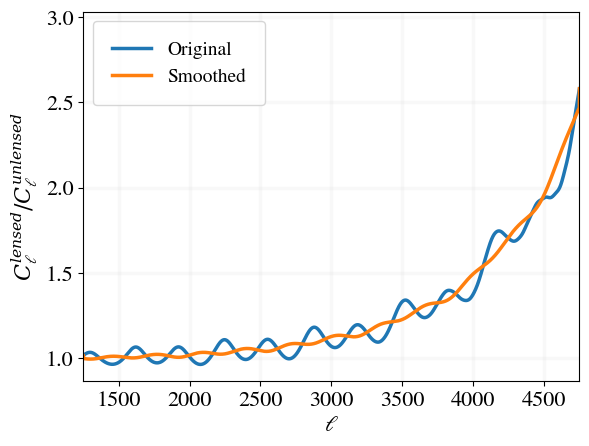

In [13]:
fig, ax = plt.subplots(1, 1)

fiducial_lensing = fiducial_lensed/fiducial_unlensed

#ax.loglog(ells, fiducial_lensing)

past_ells = 1000
n_ells = 4998 - past_ells

def moving_average(x):
    val = np.convolve(x, np.ones(500), 'valid') / 500
    return val

fiducial_smoothed = np.apply_along_axis(moving_average, axis = 0, arr = fiducial_lensing[1000:])

fiducial_smoothed = np.concatenate((fiducial_lensing[:1250], fiducial_smoothed))
fiducial_smoothed = np.concatenate((fiducial_smoothed, fiducial_lensing[-249:]))

#ax.loglog(ells, fiducial_smoothed)


plt.rc("axes", prop_cycle=line_cycler)


plt.plot(ells, fiducial_lensing, label = f"Original", lw=2.5)
plt.plot(ells, fiducial_smoothed, label = f"Smoothed", lw=2.5)


#plt.loglog([0.007, 0.007],[7e-5, 1], label = "$k_{eq}$")
#plt.semilogx(a.khs*a.h, a.GA_transfer, label = f"GA")
#plt.semilogx(a.khs*a.h, a.BBKS_transfer, label = f"BBKS")
#plt.semilogx(a.khs*a.h, a.EH_transfer, label = f"EH")
plt.grid(alpha=0.15, color='lightgray', lw=2.5)

plt.xlim(1250, 4750)

plt.ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 16)
plt.xlabel("$\ell$", fontsize = 16)
plt.legend(loc="upper left", fontsize = 14, borderpad = 1)

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.savefig("fiducial_smoothing.pdf", format="pdf", bbox_inches='tight')

In [14]:
ombh2vals = np.array([0.012, 0.02])
omch2vals = np.array([0.1, 0.13])

par_arr = []
lensing_tails = []

for _ombh2 in ombh2vals:
    for _omch2 in omch2vals:

        par_arr.append((_ombh2, _omch2))
        
        pars = camb.set_params(H0 = 67.4, ombh2 = _ombh2, omch2 = _omch2, lmax=5000)
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        lensing_tails.append(powers['total'][2:5000, 0]/ powers['unlensed_total'][2:5000, 0])


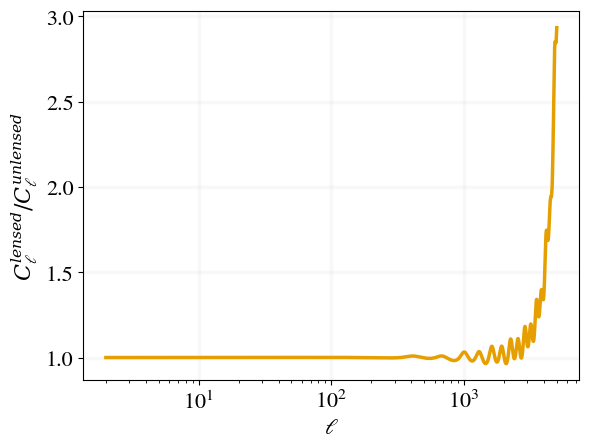

In [15]:
plt.rc("axes", prop_cycle=line_cycler)


plt.semilogx(ells, fiducial_lensing, label = f"CAMB", lw=2.5)

#plt.loglog([0.007, 0.007],[7e-5, 1], label = "$k_{eq}$")
#plt.semilogx(a.khs*a.h, a.GA_transfer, label = f"GA")
#plt.semilogx(a.khs*a.h, a.BBKS_transfer, label = f"BBKS")
#plt.semilogx(a.khs*a.h, a.EH_transfer, label = f"EH")
plt.grid(alpha=0.15, color='lightgray', lw=2.5)

plt.ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 16)
plt.xlabel("$\ell$", fontsize = 16)
#plt.legend()

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.savefig("fiducial_lensing_tail.pdf", format="pdf", bbox_inches='tight')

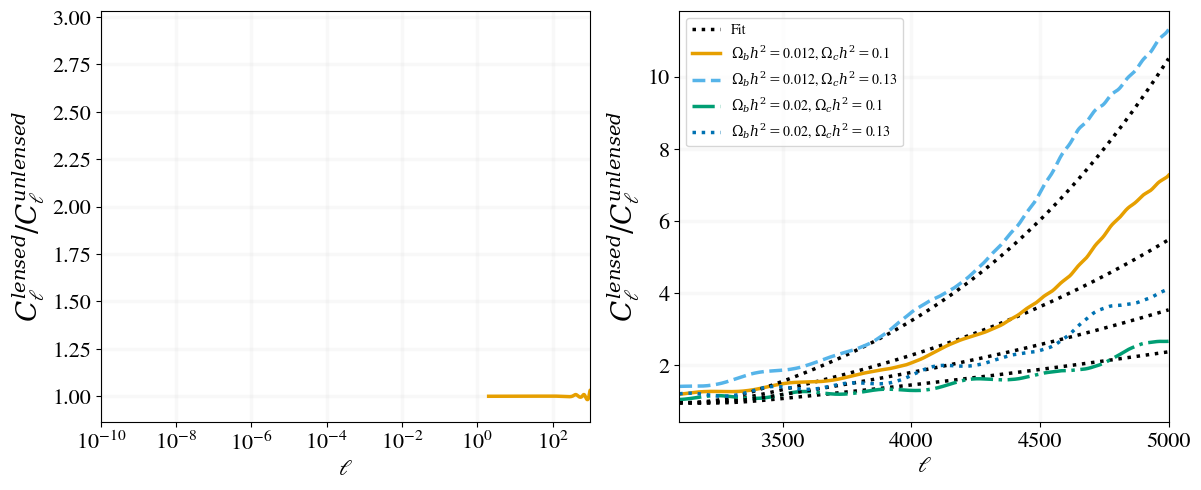

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    if i == 0:
        ax[1].plot(ells, lensing_tail_fit(ells, par_arr[i][0], par_arr[i][1]), linestyle = ":", color = "k",label = rf"Fit", lw=2.5)
    else:
        ax[1].plot(ells, lensing_tail_fit(ells, par_arr[i][0], par_arr[i][1]), linestyle = ":", color = "k", lw=2.5)#, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)
    
    ax[1].plot(ells, lensings, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)



ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_xlim(1e-10, 1000)
ax[1].set_xlim(3100, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
#plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')

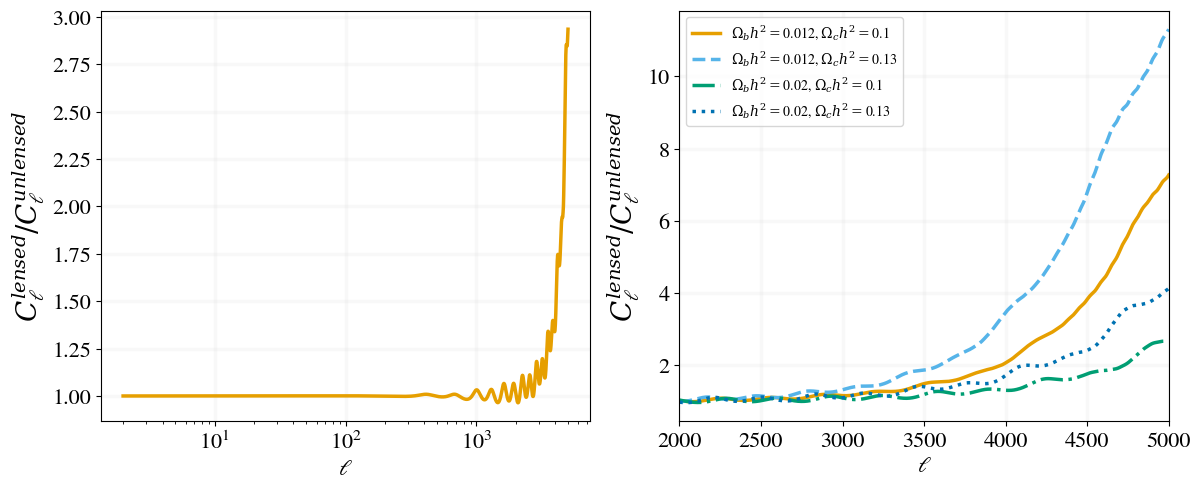

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    ax[1].plot(ells, lensings, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[1].set_xlim(2000, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')

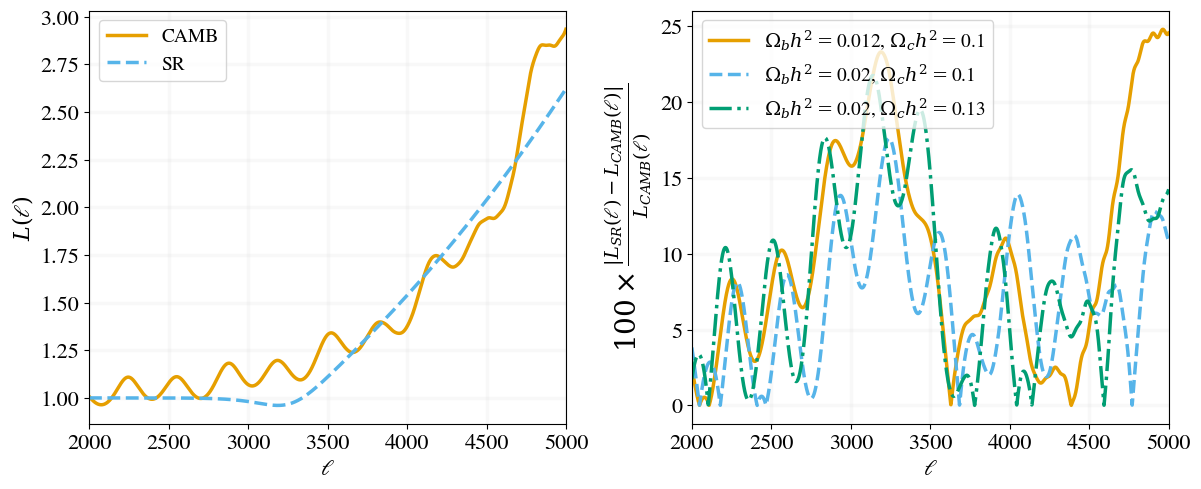

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)


ax[0].plot(ells, fiducial_lensing, lw=2.5, label = "CAMB")
ax[0].plot(ells, lensing_tail_fit(ells, 0.0224, 0.12), lw=2.5, label = "SR")


for i, lensings in enumerate(lensing_tails):
    if i == 0 or i == 2 or i == 3:
        omb = par_arr[i][0]
        omc = par_arr[i][1]
    
        fit = lensing_tail_fit(ells, omb, omc)
        
        ax[1].plot(ells, 100*np.abs(fit-lensings)/lensings, label = rf"$\Omega_bh^2=${round(omb, 4)}, $\Omega_ch^2=${round(omc, 3)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$L(\ell)$", fontsize = 16)
ax[0].set_xlabel("$\ell$", fontsize = 16)

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[0].set_xlim(2000, 5000)
ax[1].set_xlim(2000, 5000)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)


ax[1].set_ylabel(r"$100\times\frac{|L_{SR}(\ell) - L_{CAMB}(\ell)|}{L_{CAMB}(\ell)}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[0].legend(fontsize = 14)

ax[1].legend(fontsize = 14)

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
plt.savefig("lensing_tail_errors.pdf", format="pdf", bbox_inches='tight')

In [19]:


def average_error(omb, omc):
    ells_2000 = np.array([ell for ell in range(3200, 5000)])

    n_ells = len(ells_2000)
    
    pars = camb.set_params(H0 = 67.4, ombh2 = omb, omch2 = omc, lmax=5000)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    camb_lensing = powers['total'][3200:5000, 0]/ powers['unlensed_total'][3200:5000, 0]

    fit = lensing_tail_fit(ells_2000, omb, omc)

    errs = 100*np.abs(fit-camb_lensing)/camb_lensing

    return errs.sum()/n_ells



In [20]:
ombh2vals = np.array([0.012, 0.02])
omch2vals = np.array([0.1, 0.13])

for omb in ombh2vals:
    for omc in omch2vals:
        print(f"omb = {omb}, omc = {omc}, avg_error: {average_error(omb, omc)}")


omb = 0.012, omc = 0.1, avg_error: 10.38744046100875
omb = 0.012, omc = 0.13, avg_error: 11.13355495763895
omb = 0.02, omc = 0.1, avg_error: 7.914417311648099
omb = 0.02, omc = 0.13, avg_error: 8.489998177669865


In [21]:
ombh2_vals_meshgrid = np.linspace(0.006, 0.04, 10)
omch2_vals_meshgrid = np.linspace(0.05, 0.3, 10)

lensing_avg_error = np.zeros((10, 10))

for i, omb in enumerate(ombh2_vals_meshgrid):
    for j, omc in enumerate(omch2_vals_meshgrid):
        
        print(f"currently: {10*i + j + 1}/100")
        
        lensing_avg_error[i, j] = average_error(omb, omc)

currently: 1/100
currently: 2/100
currently: 3/100
currently: 4/100
currently: 5/100
currently: 6/100
currently: 7/100
currently: 8/100
currently: 9/100
currently: 10/100
currently: 11/100
currently: 12/100
currently: 13/100
currently: 14/100
currently: 15/100
currently: 16/100
currently: 17/100
currently: 18/100
currently: 19/100
currently: 20/100
currently: 21/100
currently: 22/100
currently: 23/100
currently: 24/100
currently: 25/100
currently: 26/100
currently: 27/100
currently: 28/100
currently: 29/100
currently: 30/100
currently: 31/100
currently: 32/100
currently: 33/100
currently: 34/100
currently: 35/100
currently: 36/100
currently: 37/100
currently: 38/100
currently: 39/100
currently: 40/100
currently: 41/100
currently: 42/100
currently: 43/100
currently: 44/100
currently: 45/100
currently: 46/100
currently: 47/100
currently: 48/100
currently: 49/100
currently: 50/100
currently: 51/100
currently: 52/100
currently: 53/100
currently: 54/100
currently: 55/100
currently: 56/100
c

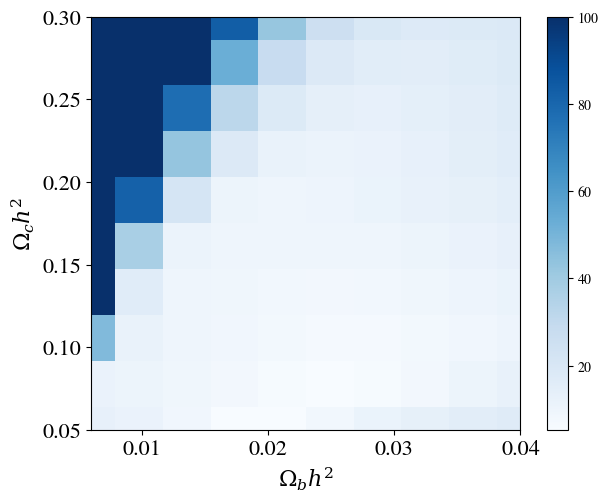

In [22]:
x, y = np.meshgrid(omch2_vals_meshgrid, ombh2_vals_meshgrid)

fig, ax = plt.subplots(1, 1)

z1 = lensing_avg_error

c = ax.pcolormesh(y, x, z1, cmap='Blues', vmax = 100)
ax.axis([y.min(), y.max(), x.min(), x.max() ])

#ax.set_title('EH', fontsize = 16, fontname="Helvetica")

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

fig.tight_layout()

fig.colorbar(c, ax=ax)

ax.set_ylabel(r"$\Omega_c h^2$", fontsize = 16)
ax.set_xlabel(r"$\Omega_b h^2$", fontsize = 16)

plt.savefig("lensing_tail_errors_grid.pdf", format="pdf", bbox_inches='tight')

In [23]:
pars     = np.load('CL_data/parameter_test2.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL2.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL2.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [24]:
lensing_tails = lensed/unlensed

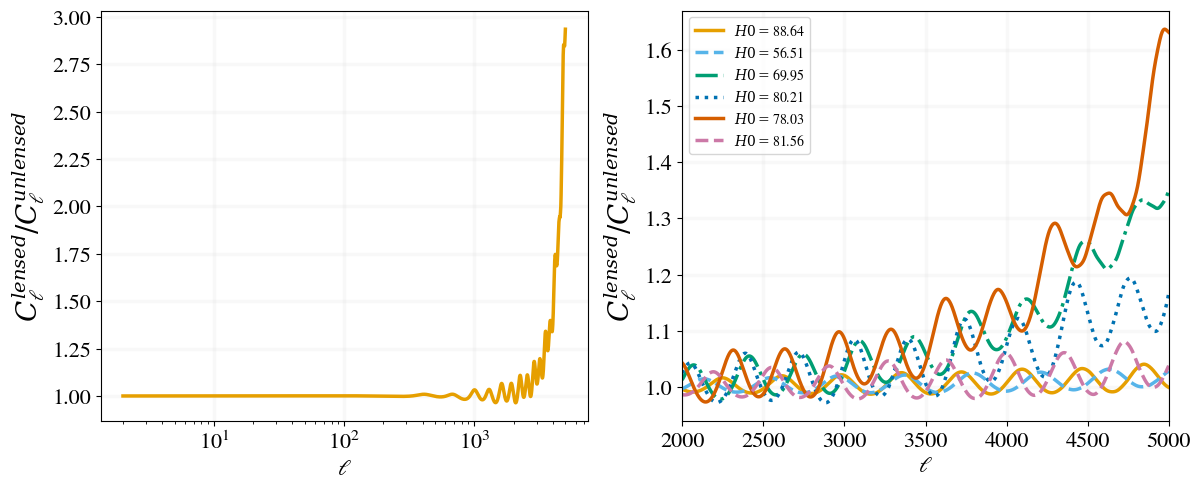

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    if i <=5 :
        ax[1].plot(ells, lensings, label = rf"$H0=${round(pars[i, 0], 2)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

#ax[0].set_xlim(1e-10, 1000)
ax[1].set_xlim(2000, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
#plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')